In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import AdaBoostClassifier as abc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import graphviz 
import seaborn as sns
from sklearn.tree import plot_tree as pt
from sklearn.tree import export_graphviz as eg
#%matplotlib notebook

# Load Data

In [2]:
stlb_df = pd.read_csv('../../STL_DATA/NHL_STL_Blues_2019.csv')
bb_df = pd.read_csv('../../STL_DATA/NHL_Boston_Bruins_2019.csv')

In [3]:
print(stlb_df.shape)
print(bb_df.shape)

(51, 18)
(94, 18)


# Combine teams

In [4]:
df = pd.concat([stlb_df, bb_df])
df.drop(columns=['League', 'Coach'], inplace=True) #
pd.concat([df.head(), df.tail()])

,Season,Team,Division,GP,W,L,T,OTL,SOL,Pts,Pct,GF,GA,PIM,Atten.,Result
0,1967-68,St. Louis Blues,Western,74,27,31,16,0,0,70,0.473,177,191,792,8897.0,Lost in Finals
1,1968-69,St. Louis Blues,Western,76,37,25,14,0,0,88,0.579,204,157,838,14436.0,Lost in Finals
2,1969-70,St. Louis Blues,Western,76,37,27,12,0,0,86,0.566,224,179,876,16389.0,Lost in Finals
3,1970-71,St. Louis Blues,West,78,34,25,19,0,0,87,0.558,223,208,1092,18238.0,Lost in round 1
4,1971-72,St. Louis Blues,West,78,28,39,11,0,0,67,0.429,208,247,1150,18376.0,Lost in round 2
89,2014-15,Boston Bruins,Atlantic,82,41,27,0,4,10,96,0.585,213,211,0,17565.0,Out of Playoffs
90,2015-16,Boston Bruins,Atlantic,82,42,31,0,7,2,93,0.567,240,230,0,18777.0,Out of Playoffs
91,2016-17,Boston Bruins,Atlantic,82,44,31,0,4,3,95,0.579,234,212,0,17565.0,Lost in round 1
92,2017-18,Boston Bruins,Atlantic,82,50,20,0,9,3,112,0.683,270,214,0,17565.0,Lost in round 2
93,2018-19,Boston Bruins,Atlantic,82,49,24,0,6,3,107,0.652,259,215,0,17565.0,NaN


# Encode season result

In [5]:
def result_end(row):
    if row.Result == 'Won Championship':
        return 5
    if row.Result == 'Lost in Finals':
        return 4
    if row.Result == 'Lost in round 3':
        return 3
    if row.Result == 'Lost in round 2':
        return 2
    if row.Result == 'Lost in round 1':
        return 1
    if row.Result == 'Out of Playoffs':
        return 0
    return -1
df['ending'] = df.apply(lambda row: result_end(row), axis=1)

In [6]:
df.groupby(['Team', 'Result']).Season.nunique()

Team             Result          
Boston Bruins    Lost in Finals      13
                 Lost in round 1     34
                 Lost in round 2     13
                 Lost in round 3      5
                 Out of Playoffs     22
                 Won Championship     6
St. Louis Blues  Lost in Finals       3
                 Lost in round 1     19
                 Lost in round 2     16
                 Lost in round 3      3
                 Out of Playoffs      9
Name: Season, dtype: int64

In [7]:
df.groupby(['Team', 'ending']).Season.nunique()  # checking whether we encoded correctly

Team             ending
Boston Bruins    -1         1
                  0        22
                  1        34
                  2        13
                  3         5
                  4        13
                  5         6
St. Louis Blues  -1         1
                  0         9
                  1        19
                  2        16
                  3         3
                  4         3
Name: Season, dtype: int64

#### Encode whether team gets into playoffs to setup a binary classification

In [8]:
def if_in_playoffs(row):
    if row.Result == 'Out of Playoffs':
        return 0
    return 1
df['in_playoffs'] = df.apply(lambda row: if_in_playoffs(row), axis=1)

In [9]:
df.groupby(['Team', 'in_playoffs']).Season.nunique()

Team             in_playoffs
Boston Bruins    0              22
                 1              72
St. Louis Blues  0               9
                 1              42
Name: Season, dtype: int64

#### Encode whether team gets to at least round 2 of playoffs to setup a binary classification

Notice that *in_playoffs* is still imbalanced

In [10]:
def if_past_round_1(row):
    if row.Result == 'Out of Playoffs' or row.Result == 'Lost in round 1':
        return 0
    return 1
df['past_round_1'] = df.apply(lambda row: if_past_round_1(row), axis=1)

In [11]:
df.groupby(['Team', 'past_round_1']).Season.nunique()

Team             past_round_1
Boston Bruins    0               56
                 1               38
St. Louis Blues  0               28
                 1               23
Name: Season, dtype: int64

In [12]:
df.columns.sort_values()

Index(['Atten.', 'Division', 'GA', 'GF', 'GP', 'L', 'OTL', 'PIM', 'Pct', 'Pts',
       'Result', 'SOL', 'Season', 'T', 'Team', 'W', 'ending', 'in_playoffs',
       'past_round_1'],
      dtype='object')

# List features to use

- GA = goals allowed
    - Performance of defense: higher is bad
- GF = goals for
    - Performance of offense: higher is good
- GP = games played
    - Length of season, long seasons may indicate good season; short seasons may indicate bad season or strike
- W = wins
    - higher is good
- L = losses
    - higher is bad
- T = ties
    - higher is probably bad
- OTL = overtime losses
    - higher is bad
- PIM = penalty infraction minutes
    - higher is probably bad, higher indicates more aggressive team
- Pct = shooting percentage
    - goals per shots taken, higher can be good, it can also mean less offensive team with high shooting accuracy while taking fewer shots
- Pts = total goals & assists
    - higher is good
- Atten. = average attendance (?)
    - higher may be good, more exciting teams draw crowds, but this is relative to the arena

In [13]:
features = ['GA', 'GF', 'GP', 'W', 'L', 'T', 'OTL', 'PIM', 'Pct', 'Pts', 'Atten.']
#features = ['W', 'L', 'T']
#features = ['GA', 'GF', 'Pct', 'Pts']

# Predict

## Let's try to predict if a team will make it past the first round of the playoffs.
aka predict *past_round_1* column

Decision tree classifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [14]:
class_column = 'past_round_1'

## Train test split

In [15]:
stanley_cup = df[df.Season=='2018-19']
df = df[~df.Result.isnull()]
X = df.loc[:, features].fillna(method='bfill')  # backfill, assuming consecutive years have similar stats
y = df.loc[:, class_column]

In [16]:
X_train, X_test, y_train, y_test = tts( \
    X, y, test_size=0.33, random_state=5)

## Train

In [17]:
tree = dtc()
#tree = dtc(criterion='entropy', max_depth=2, min_samples_split=2, min_samples_leaf=2)
#tree = dtc(criterion='gini', max_depth=5, min_samples_split=3, min_samples_leaf=15)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Review tree
I needed to install graphviz both by pip/conda & standalone (on Mac, I used brew)

#### Feature importance

Here we can inspect what features seem to be most important to *this* model to answer our question.

We can begin asking:
- Do the importances make logical sense?
- Should we use different features?
- Should we drop some features?
- Given the test result, should we get more (or less) data or features?

In [18]:
pd.DataFrame(data=tree.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
W,0.399891
GF,0.141746
GA,0.135307
Atten.,0.127828
L,0.094340
Pct,0.070206
GP,0.018828
Pts,0.011855
T,0.000000
OTL,0.000000


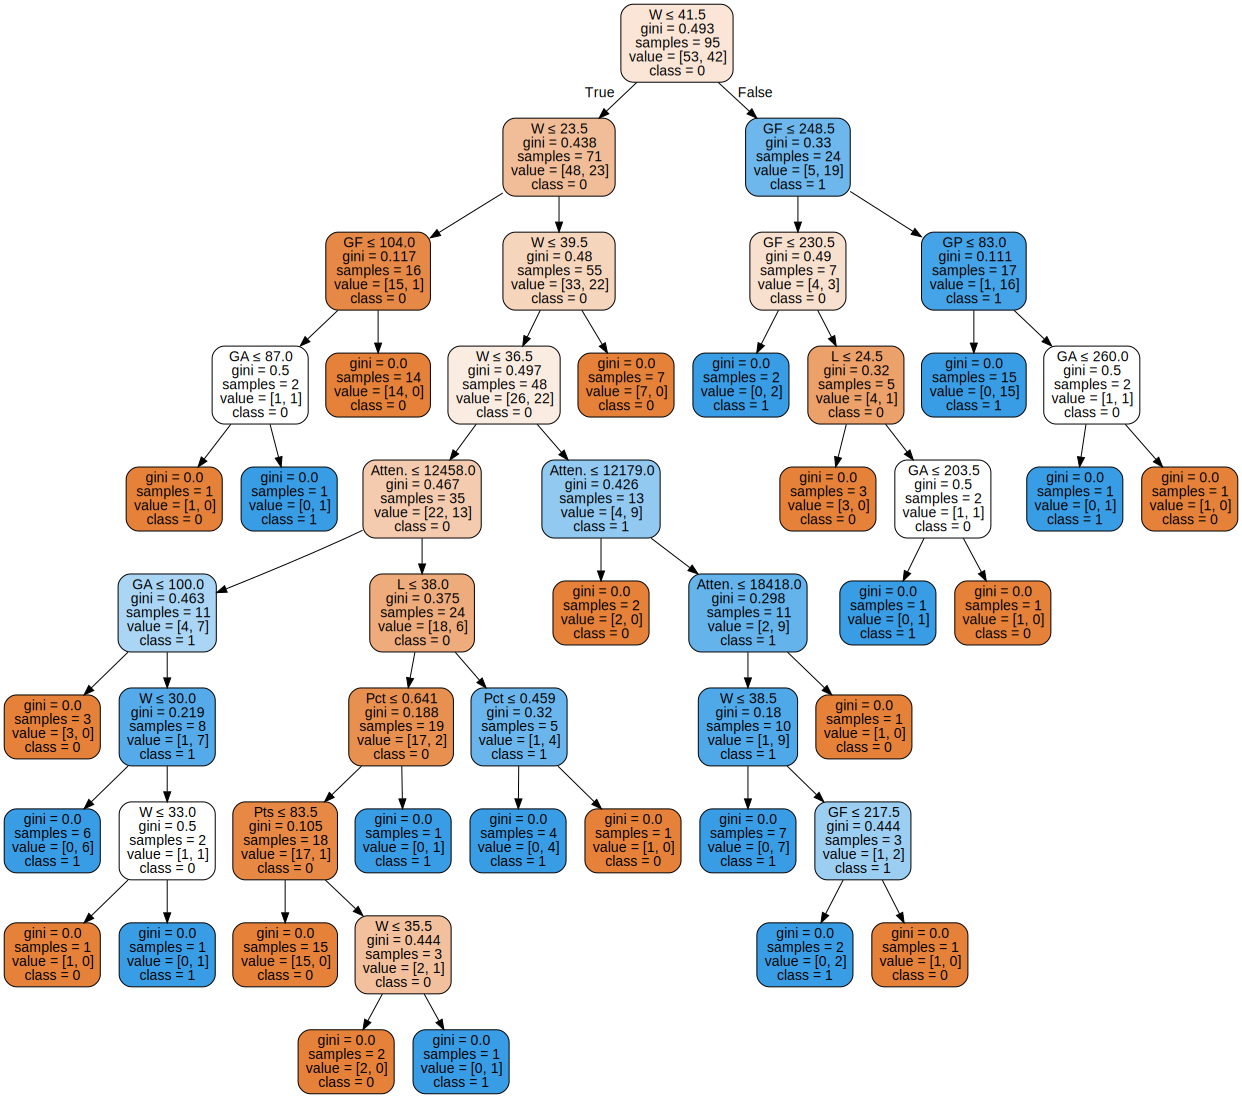

In [19]:
dot_data = eg(tree, out_file=None, 
    feature_names=features,  
    class_names=[str(x) for x in np.sort(df[class_column].unique())],  
    filled=True, rounded=True,  
    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph
# Read each row in the nodes as...
### Splitting condition
### criterion measure of splitting condition
### number of samples in node
### number of samples in each class (regardless of the splitting condition)
### classification given to samples in the node

### Test

In [20]:
tree.score(X_test, y_test) # accuracy

0.5

In [21]:
tree.get_depth() # depth of tree

9

In [22]:
tree.get_n_leaves() # number of leaves

26

### Probabilities of each class

In [23]:
pred_proba = tree.predict_proba(X_test)
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=X_test.index, columns=['prob_not_' + class_column, 'prob_' + class_column]) #columns=['out', 'round1', 'round2', 'round3', 'final', 'champion'], dtype='float')
pred = tree.predict(X_test)
print(pred.shape)
pred_df = pd.DataFrame(pred, index=X_test.index, columns=['predict_' + class_column], dtype='float')
original_data_df = X_test.merge(y_test, left_index=True, right_index=True)
with_pred_df = original_data_df.merge(pred_df, left_index=True, right_index=True)
with_prob_df = with_pred_df.merge(pred_proba_df, left_index=True, right_index=True)
with_prob_df.tail()

(48, 2)
(48,)


,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,past_round_1,predict_past_round_1,prob_not_past_round_1,prob_past_round_1
76,249,227,82,36,30,8,8,1325,0.537,88,15432.0,0,1.0,0.0,1.0
78,237,245,82,36,31,11,4,1370,0.530,87,15029.0,0,1.0,0.0,1.0
86,202,269,82,49,29,0,1,0,0.622,102,17565.0,0,1.0,0.0,1.0
88,177,261,82,54,19,0,3,886,0.713,117,17565.0,1,1.0,0.0,1.0
90,230,240,82,42,31,0,7,0,0.567,93,18777.0,0,0.0,1.0,0.0


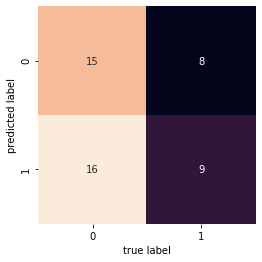

In [24]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Train adaboost

In [25]:
abc_tree = abc()
abc_tree.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

### Review tree

In [26]:
pd.DataFrame(data=abc_tree.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
W,0.24
PIM,0.18
GF,0.14
GA,0.10
L,0.10
Atten.,0.08
Pct,0.06
Pts,0.04
GP,0.02
T,0.02


### Test

In [27]:
abc_tree.score(X_test, y_test) # accuracy

0.7083333333333334

### Probabilities of each class

In [28]:
pred_proba = abc_tree.predict_proba(X_test)
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=X_test.index, columns=['prob_not_' + class_column, 'prob_' + class_column]) #columns=['out', 'round1', 'round2', 'round3', 'final', 'champion'], dtype='float')
pred = abc_tree.predict(X_test)
print(pred.shape)
pred_df = pd.DataFrame(pred, index=X_test.index, columns=['predict_' + class_column], dtype='float')
original_data_df = X_test.merge(y_test, left_index=True, right_index=True)
with_pred_df = original_data_df.merge(pred_df, left_index=True, right_index=True)
with_prob_df = with_pred_df.merge(pred_proba_df, left_index=True, right_index=True)
with_prob_df.head()

(48, 2)
(48,)


,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,past_round_1,predict_past_round_1,prob_not_past_round_1,prob_past_round_1
0,119,49,30,6,24,0,0,264,0.200,12,6045.0,0,0.0,0.624405,0.375595
3,70,77,44,20,13,11,0,558,0.580,51,6773.0,1,0.0,0.621224,0.378776
4,52,89,44,26,13,5,0,472,0.648,57,13387.0,1,1.0,0.499142,0.500858
6,248,206,78,26,40,12,0,1147,0.410,64,18009.0,0,1.0,0.466784,0.533216
7,117,122,48,15,21,12,0,373,0.438,42,12315.0,0,0.0,0.676457,0.323543


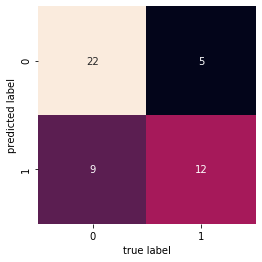

In [29]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Train gradient boosted trees

In [30]:
gbc_tree = gbc()
gbc_tree.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Review tree

In [31]:
pd.DataFrame(data=gbc_tree.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
W,0.299869
GF,0.187870
L,0.089029
Atten.,0.086473
PIM,0.083005
GA,0.068716
Pct,0.060541
Pts,0.035812
OTL,0.030448
GP,0.030041


### Test

In [32]:
gbc_tree.score(X_test, y_test) # accuracy

0.6458333333333334

### Probabilities of each class

In [33]:
pred_proba = gbc_tree.predict_proba(X_test)
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=X_test.index, columns=['prob_not_' + class_column, 'prob_' + class_column]) #columns=['out', 'round1', 'round2', 'round3', 'final', 'champion'], dtype='float')
pred = gbc_tree.predict(X_test)
print(pred.shape)
pred_df = pd.DataFrame(pred, index=X_test.index, columns=['predict_' + class_column], dtype='float')
original_data_df = X_test.merge(y_test, left_index=True, right_index=True)
with_pred_df = original_data_df.merge(pred_df, left_index=True, right_index=True)
with_prob_df = with_pred_df.merge(pred_proba_df, left_index=True, right_index=True)
with_prob_df.head()

(48, 2)
(48,)


,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,past_round_1,predict_past_round_1,prob_not_past_round_1,prob_past_round_1
0,119,49,30,6,24,0,0,264,0.200,12,6045.0,0,0.0,0.516333,0.483667
3,70,77,44,20,13,11,0,558,0.580,51,6773.0,1,0.0,0.518874,0.481126
4,52,89,44,26,13,5,0,472,0.648,57,13387.0,1,0.0,0.723441,0.276559
6,248,206,78,26,40,12,0,1147,0.410,64,18009.0,0,0.0,0.763511,0.236489
7,117,122,48,15,21,12,0,373,0.438,42,12315.0,0,0.0,0.861455,0.138545


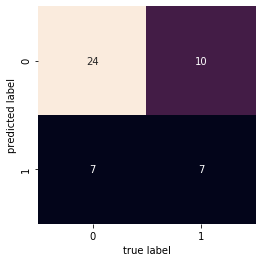

In [34]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Train random forest

In [35]:
rf_tree = rf()
rf_tree.fit(X_train, y_train)

/Users/adscot/Learn/Plotting/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Review tree

In [36]:
pd.DataFrame(data=rf_tree.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
GF,0.163102
Pct,0.156775
GA,0.114694
W,0.109548
Pts,0.097361
L,0.078609
Atten.,0.072095
PIM,0.069056
T,0.062589
OTL,0.039718


### Test

In [37]:
rf_tree.score(X_test, y_test) # accuracy

0.6875

### Probabilities of each class

In [38]:
pred_proba = rf_tree.predict_proba(X_test)
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=X_test.index, columns=['prob_not_' + class_column, 'prob_' + class_column]) #columns=['out', 'round1', 'round2', 'round3', 'final', 'champion'], dtype='float')
pred = rf_tree.predict(X_test)
print(pred.shape)
pred_df = pd.DataFrame(pred, index=X_test.index, columns=['predict_' + class_column], dtype='float')
original_data_df = X_test.merge(y_test, left_index=True, right_index=True)
with_pred_df = original_data_df.merge(pred_df, left_index=True, right_index=True)
with_prob_df = with_pred_df.merge(pred_proba_df, left_index=True, right_index=True)
with_prob_df.head()

(48, 2)
(48,)


,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,past_round_1,predict_past_round_1,prob_not_past_round_1,prob_past_round_1
0,119,49,30,6,24,0,0,264,0.200,12,6045.0,0,0.0,0.9,0.1
3,70,77,44,20,13,11,0,558,0.580,51,6773.0,1,0.0,0.5,0.5
4,52,89,44,26,13,5,0,472,0.648,57,13387.0,1,0.0,0.7,0.3
6,248,206,78,26,40,12,0,1147,0.410,64,18009.0,0,1.0,0.3,0.7
7,117,122,48,15,21,12,0,373,0.438,42,12315.0,0,0.0,0.7,0.3


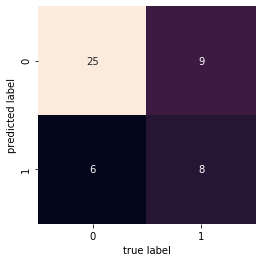

In [39]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Grid search

In [40]:
vals = [None, 3, 6]
finite_vals = [2, 4, 6]
attempts = list()
X_train, X_test, y_train, y_test = tts( \
    df[features].fillna(-1), df['past_round_1'], \
    test_size=0.33, random_state=42)
best_accuracy = 0
best_list = list()
best_tree = dtc()
for crit in ['gini', 'entropy']:
    for max_d in vals:
        for min_ss in finite_vals:
            for min_sl in finite_vals:
                tree = dtc(criterion=crit, \
                    max_depth=max_d, min_samples_split=min_ss, min_samples_leaf=min_sl)
                tree.fit(X_train, y_train)
                accuracy = tree.score(X_test, y_test)
                fit_depth = tree.get_depth()
                fit_leaf = tree.get_n_leaves()
                attempt = [accuracy, crit, max_d, min_ss, min_sl, fit_depth, fit_leaf]
                attempts.append(attempt)
                if accuracy > best_accuracy:
                    best_params = tree.get_params()
                    best_list = attempt
                    best_tree = tree
result_df = pd.DataFrame(attempts, \
    columns=['accuracy', 'criterion', 'max_depth', 'min_samples_split', \
    'min_samples_leaf', 'fit_depth', 'fit_leaf'])
result_df.sort_values(['accuracy', 'criterion', \
    'max_depth', 'min_samples_split', \
    'min_samples_leaf', 'fit_depth', 'fit_leaf'])\
    .drop_duplicates('accuracy')

,accuracy,criterion,max_depth,min_samples_split,min_samples_leaf,fit_depth,fit_leaf
4,0.458333,gini,NaN,4,4,5,13
22,0.479167,gini,6.0,4,4,5,13
36,0.500000,entropy,3.0,2,2,3,8
46,0.520833,entropy,6.0,2,4,6,13
6,0.541667,gini,NaN,6,2,7,17
37,0.562500,entropy,3.0,2,4,3,8
47,0.583333,entropy,6.0,2,6,5,10
49,0.604167,entropy,6.0,4,4,6,13


### Notes
simple model generally generalizes better/avoids overfitting

fewer features - reduce overfitting

more data - reduce variance

predict current year

### Review grid search best model results

In [41]:
best_params

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [42]:
best_list

[0.5833333333333334, 'entropy', 6, 6, 6, 5, 10]

In [43]:
pd.DataFrame(data=best_tree.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
Pct,0.418735
PIM,0.262089
GA,0.170638
GF,0.109026
OTL,0.039511
GP,0.000000
W,0.000000
L,0.000000
T,0.000000
Pts,0.000000


## Predict
### Which team was more likely to win the Stanley Cup for the 2018-19 season OR what is the most likely result (depth in the playoffs) for each team?
Since the Blues had never won the championship before, we need to consider how to sample some championships. I am simply combining both teams again, but this time, we can use the ending column to do a multi-classification model to predict winning the championship.

In [44]:
stanley_cup  # carved out earlier before the DTC train-test-split

,Season,Team,Division,GP,W,L,T,OTL,SOL,Pts,Pct,GF,GA,PIM,Atten.,Result,ending,in_playoffs,past_round_1
50,2018-19,St. Louis Blues,Central,82,45,28,0,6,3,99,0.604,247,223,0,17362.0,NaN,-1,1,1
93,2018-19,Boston Bruins,Atlantic,82,49,24,0,6,3,107,0.652,259,215,0,17565.0,NaN,-1,1,1


In [45]:
class_column = 'ending'

## Train test split

In [46]:
y = df.loc[:, class_column]

In [47]:
X_train, X_test, y_train, y_test = tts( \
    X, y, test_size=0.2, random_state=5)

## Train

In [48]:
SC_model = dtc()
#SC_model = abc()
#SC_model = gbc()
#SC_model = rf()
SC_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Review tree
I needed to install graphviz both by pip/conda & standalone (on Mac, I used brew)

#### Feature importance

Here we can inspect what features seem to be most important to *this* model to answer our question.

We can begin asking:
- Do the importances make logical sense?
- Should we use different features?
- Should we drop some features?
- Given the test result, should we get more (or less) data or features?

In [49]:
pd.DataFrame(data=SC_model.feature_importances_, \
    index=features).sort_values(0, ascending=False)

,0
Pct,0.214737
T,0.168534
Atten.,0.157611
GF,0.135446
PIM,0.089063
Pts,0.061069
OTL,0.054941
GA,0.046979
GP,0.042703
L,0.028916


In [50]:
if type(SC_model) == dtc:
    dot_data = eg(SC_model, out_file=None, 
        feature_names=features,  
        class_names=[str(x) for x in np.sort(df[class_column].unique())],  
        filled=True, rounded=True,  
        special_characters=True)  
    SC_graph = graphviz.Source(dot_data)  
    SC_graph.view()
    # Read each row in the nodes as...
    ### Splitting condition
    ### criterion measure of splitting condition
    ### number of samples in node
    ### number of samples in each class (regardless of the splitting condition)
    ### classification given to samples in the node

### Test

In [51]:
SC_model.score(X_test, y_test) # accuracy

0.4827586206896552

In [52]:
if type(SC_model) == dtc:
    print(SC_model.get_depth()) # depth of tree

10


In [53]:
if type(SC_model) == dtc:
    print(SC_model.get_n_leaves()) # number of leaves

47


### Probabilities of each class

The following throws an error. Can you tell why?

Hint: What endings had we observed of the STL Blues before the 2018-19 season?

Consideration: Can a model predict an event that it has never seen before? Is this a limitation of decision trees or general ML models?

In [54]:
pred_proba = SC_model.predict_proba(X_test)
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=X_test.index, columns=['pred_' + x for x in ['out', 'round1', 'round2', 'round3', 'final', 'champion']], dtype='float')
pred = SC_model.predict(X_test)
print(pred.shape)
pred_df = pd.DataFrame(pred, index=X_test.index, columns=['predict_' + class_column], dtype='float')
original_data_df = X_test.merge(y_test, left_index=True, right_index=True)
with_pred_df = original_data_df.merge(pred_df, left_index=True, right_index=True)
with_prob_df = with_pred_df.merge(pred_proba_df, left_index=True, right_index=True)
with_prob_df.head()

(29, 6)
(29,)


,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,ending,predict_ending,pred_out,pred_round1,pred_round2,pred_round3,pred_final,pred_champion
0,119,49,30,6,24,0,0,264,0.200,12,6045.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,70,77,44,20,13,11,0,558,0.580,51,6773.0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,117,122,48,15,21,12,0,373,0.438,42,12315.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,112,129,48,26,16,6,0,368,0.604,58,10241.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
10,112,129,48,26,16,6,0,368,0.604,58,10241.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0


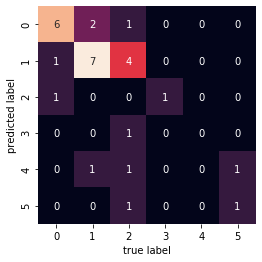

In [55]:
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [56]:
stanley_cup

,Season,Team,Division,GP,W,L,T,OTL,SOL,Pts,Pct,GF,GA,PIM,Atten.,Result,ending,in_playoffs,past_round_1
50,2018-19,St. Louis Blues,Central,82,45,28,0,6,3,99,0.604,247,223,0,17362.0,NaN,-1,1,1
93,2018-19,Boston Bruins,Atlantic,82,49,24,0,6,3,107,0.652,259,215,0,17565.0,NaN,-1,1,1


In [57]:
pred_proba = SC_model.predict_proba(stanley_cup.loc[:, features])
print(pred_proba.shape)
pred_proba_df = pd.DataFrame(pred_proba, index=stanley_cup.Team, columns=['pred_' + x for x in ['out', 'round1', 'round2', 'round3', 'final', 'champion']], dtype='float')
pred = SC_model.predict(stanley_cup.loc[:, features])
print(pred.shape)
pred_df = pd.DataFrame(pred, index=stanley_cup.Team, columns=['predict_' + class_column], dtype='float')
original_data_df = stanley_cup.loc[:, ['Team'] + features].merge(stanley_cup.loc[:, ['Team', class_column]], on='Team')
with_pred_df = original_data_df.merge(pred_df, on='Team')
with_prob_df = with_pred_df.merge(pred_proba_df, on='Team')
with_prob_df.head()

(2, 6)
(2,)


,Team,GA,GF,GP,W,L,T,OTL,PIM,Pct,Pts,Atten.,ending,predict_ending,pred_out,pred_round1,pred_round2,pred_round3,pred_final,pred_champion
0,St. Louis Blues,223,247,82,45,28,0,6,0,0.604,99,17362.0,-1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Boston Bruins,215,259,82,49,24,0,6,0,0.652,107,17565.0,-1,5.0,0.0,0.0,0.0,0.0,0.0,1.0


#### So, how well should have each team done in the 2018-19 season? 

#### Which team was more likely to win the Stanley Cup in the 2018-19 season?

## Which model do you trust more? Why?
You can swap out the SC_model at the beginning of this section of the notebook. Given all of the shortcomings our data has, what is the best model that you can make?